In [ ]:
# modules needed
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from medmnist import BloodMNIST as bt
from main import BloodCNN


In [18]:
# Classes for visualization
classes = [
    "Neutrophil", "Eosinophil", "Basophil", "Lymphocyte",
    "Monocyte", "Immature Granulocyte", "Erythroblast", "Platelet"
]

# Data Loaders
def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    train = bt(split='train', transform=transform, download=True)
    val = bt(split='val', transform=transform, download=True)
    test = bt(split='test', transform=transform, download=True)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size)
    test_loader = DataLoader(test, batch_size=batch_size)  
    
    return train_loader, val_loader, test_loader




In [19]:
def show_sample_images(data_loader):
    images, labels = next(iter(data_loader))
    images = images[:8]
    labels = labels[:8]

    fig, axes = plt.subplots(1, 8, figsize=(15, 3))

    for i in range(8):
        img = images[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        img = (img * 0.5) + 0.5

        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(classes[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()




In [20]:
class BloodCNN(nn.Module):
    def __init__(self):
        super(BloodCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input channels = 3 for RGB
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 8)  # 8 classes
        )

    def forward(self, x):
        return self.model(x)


In [21]:
def train_model(model, train_loader, val_loader, epochs=5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.squeeze().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"\nEpoch {epoch+1}/{epochs} | Training Loss: {total_loss:.4f}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.squeeze().to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")



In [22]:
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


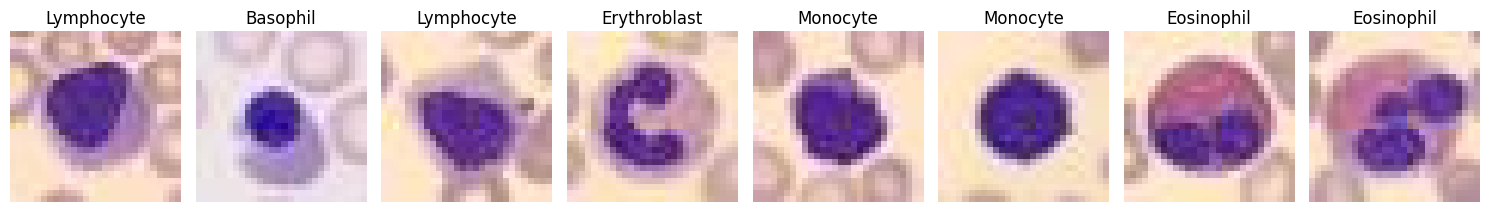


Epoch 1/50 | Training Loss: 155.7371
Validation Accuracy: 81.43%

Epoch 2/50 | Training Loss: 78.5301
Validation Accuracy: 86.27%

Epoch 3/50 | Training Loss: 61.9104
Validation Accuracy: 89.25%

Epoch 4/50 | Training Loss: 52.7890
Validation Accuracy: 88.43%

Epoch 5/50 | Training Loss: 46.4428
Validation Accuracy: 90.13%

Epoch 6/50 | Training Loss: 41.8041
Validation Accuracy: 91.24%

Epoch 7/50 | Training Loss: 39.8167
Validation Accuracy: 89.84%

Epoch 8/50 | Training Loss: 35.1797
Validation Accuracy: 87.56%

Epoch 9/50 | Training Loss: 30.4028
Validation Accuracy: 91.82%

Epoch 10/50 | Training Loss: 28.2690
Validation Accuracy: 91.47%

Epoch 11/50 | Training Loss: 23.7777
Validation Accuracy: 91.18%

Epoch 12/50 | Training Loss: 21.9237
Validation Accuracy: 91.82%

Epoch 13/50 | Training Loss: 19.1161
Validation Accuracy: 92.82%

Epoch 14/50 | Training Loss: 16.8316
Validation Accuracy: 93.22%

Epoch 15/50 | Training Loss: 13.4215
Validation Accuracy: 93.34%

Epoch 16/50 | Tra

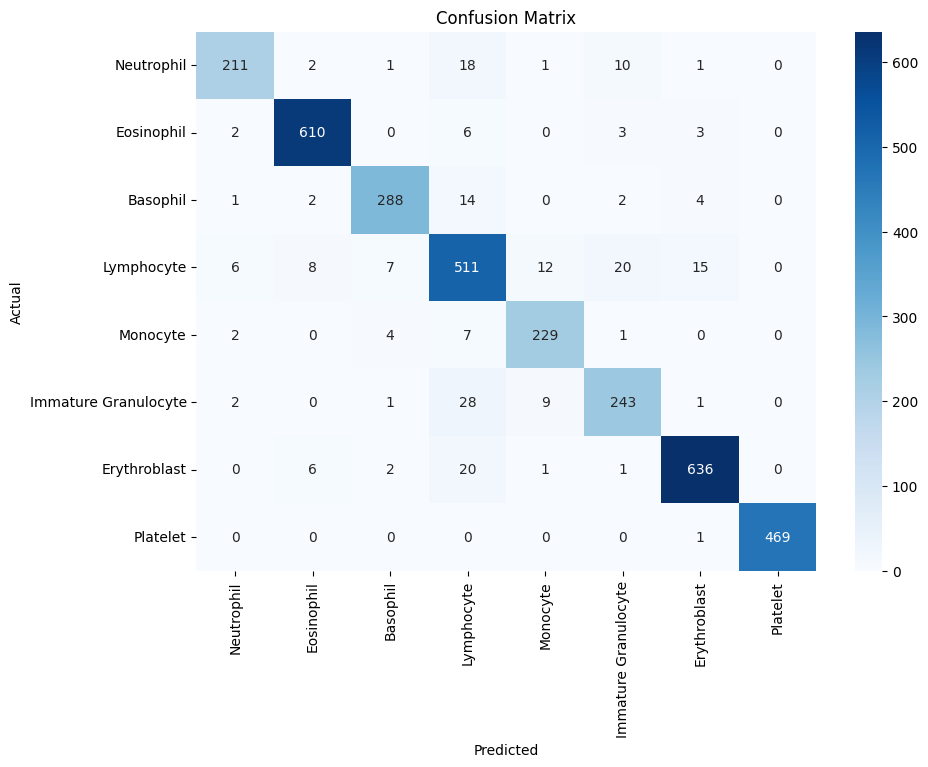

In [24]:
if __name__ == "__main__":
    train_loader, val_loader, test_loader = get_data_loaders()
    show_sample_images(train_loader)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = BloodCNN()
    train_model(model, train_loader, val_loader, epochs=50, device=device)

    evaluate_model(model, test_loader, device=device)

    torch.save(model.state_dict(), "bloodcnn.pth")